In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset
from utils.train_utils import CondOT_flow, CondOT_ut, validate
from utils.plotting import plot_flow, plot_error_for_each_point
from utils.schemes import Euler, RK4
from utils.utils import *

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
run_parameters =  yaml.safe_load(Path("./configs/base.yaml").read_text())
run_parameters

{'lr': 0.0001,
 'epochs': 10001,
 'batch_size': 1200,
 'inf_every': 1000,
 'print_every': 500,
 'dim': 2,
 'hidden_dim': 64,
 'horizon_size': 8,
 'inference_horizon': 4,
 'scale_factor': 2.0,
 'downsample': 5,
 'ema_warmup': 250,
 'ema_update': 5,
 'ema_decay': 0.999,
 'inf_runs_num': 3,
 'save_epoch': 6000,
 'device': 'cpu'}

In [3]:
sine_data = StatePyLASADataset("Sine", horizon_size=run_parameters['horizon_size'],
                                       scaling_factor=run_parameters['scale_factor'],
                                       downsample = run_parameters['downsample'])

train_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample']))

test_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample'], 
                                                        7000//run_parameters['downsample']))

train_sin = DataLoader(train_dataset,
                       batch_size=run_parameters['batch_size'],
                       shuffle=True)

val_sin = DataLoader(test_dataset,
                    batch_size=run_parameters['batch_size'],
                    shuffle=True)

test_sin = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _ = next(iter(test_sin))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=1000//run_parameters['downsample'],
                    shuffle=False)

gt_obs, gt_horizon = next(iter(gt_test))
gt_obs = gt_obs[:, :2]

In [4]:
vf = StateMLP(
    action_dim=run_parameters['dim'],
    hidden_dim=run_parameters['hidden_dim'],
    horizon_size=run_parameters['horizon_size'],
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema_decay'],
)

obs, a = next(iter(train_sin))
print(obs.shape, a.shape)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable param number:", params)

torch.Size([1200, 5]) torch.Size([1200, 8, 2])
Learnable param number: 40864


| iter      0 |  0.05 ms/step | loss    2.310 
| iter      0 | validation loss:    2.531 


100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


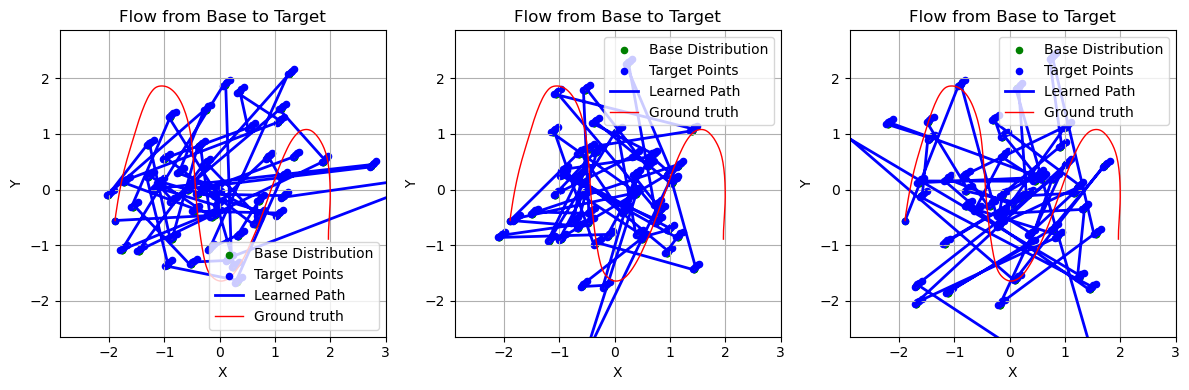

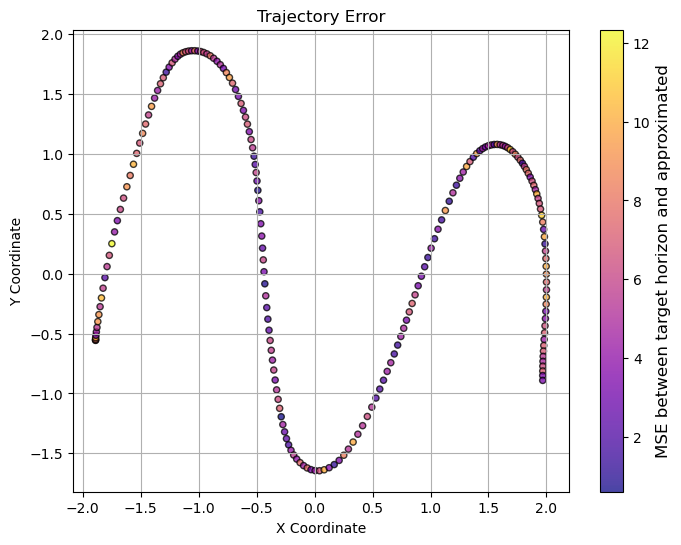

| iter    500 | 42.04 ms/step | loss    0.745 
| iter    500 | validation loss:    0.831 
| iter   1000 | 18.43 ms/step | loss    0.291 
| iter   1000 | validation loss:    0.248 


100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


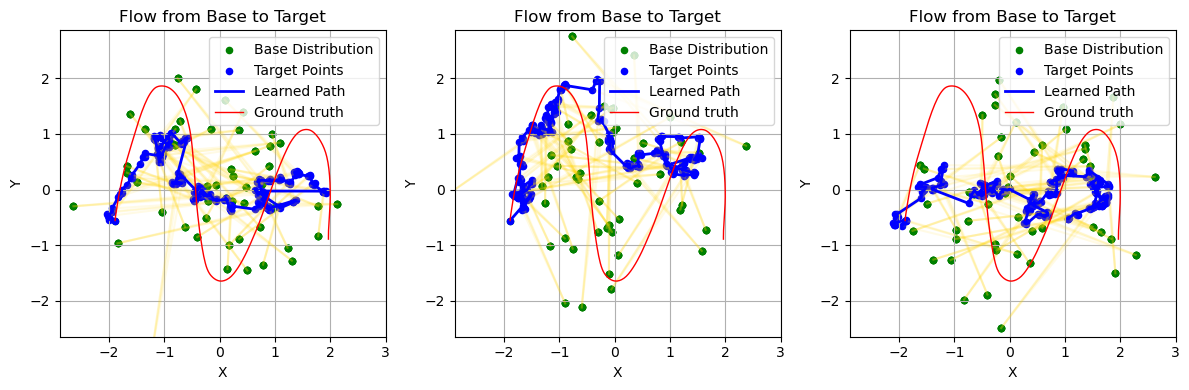

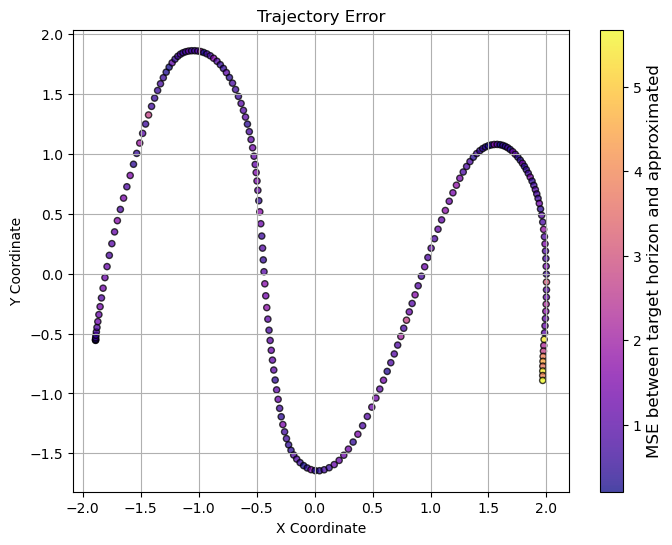

| iter   1500 | 41.27 ms/step | loss    0.198 
| iter   1500 | validation loss:    0.170 
| iter   2000 | 18.70 ms/step | loss    0.144 
| iter   2000 | validation loss:    0.192 


100%|██████████| 50/50 [00:03<00:00, 14.14it/s]


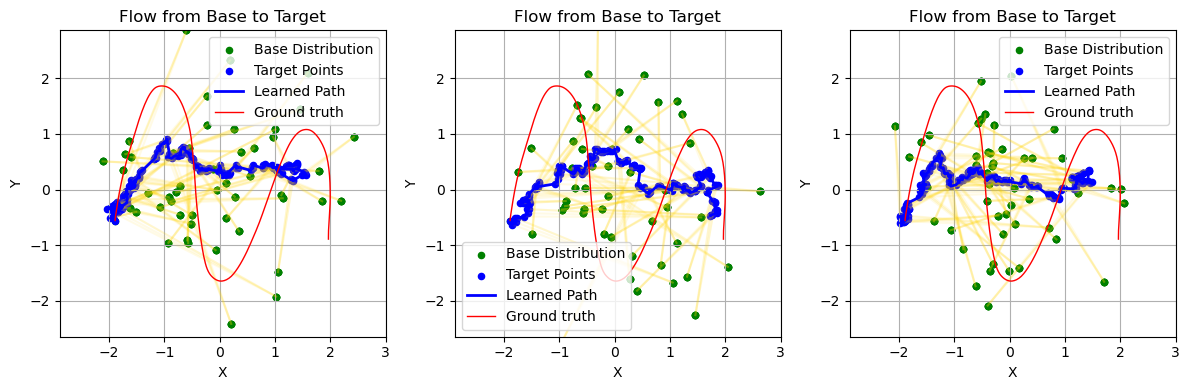

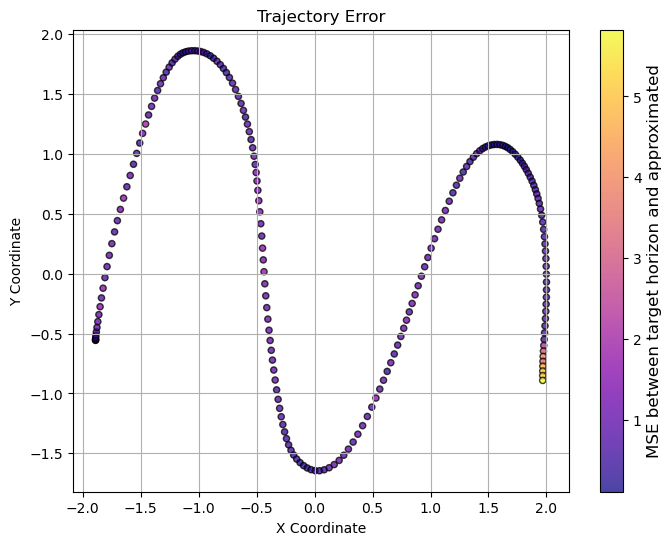

| iter   2500 | 41.91 ms/step | loss    0.151 
| iter   2500 | validation loss:    0.130 
| iter   3000 | 18.69 ms/step | loss    0.131 
| iter   3000 | validation loss:    0.203 


100%|██████████| 50/50 [00:03<00:00, 14.48it/s]


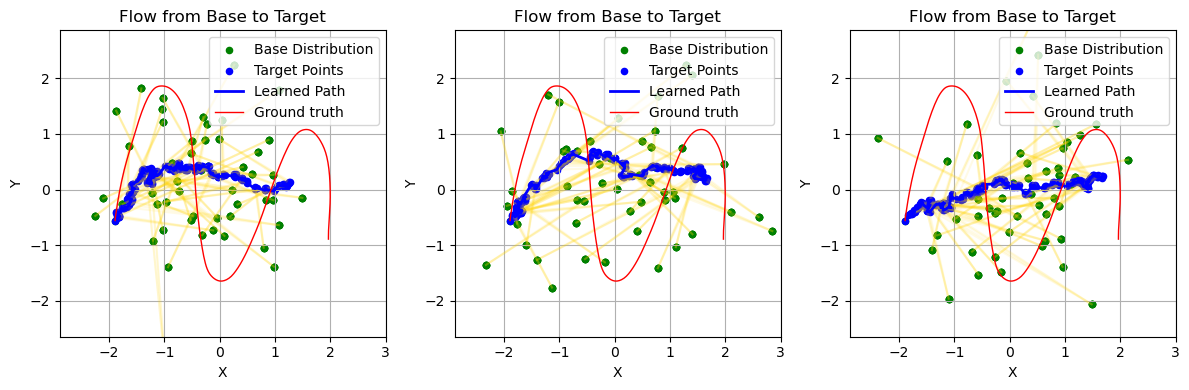

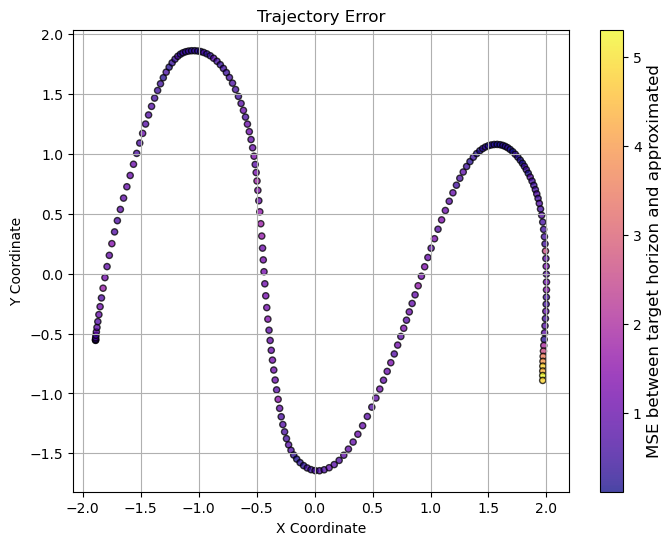

| iter   3500 | 41.70 ms/step | loss    0.132 
| iter   3500 | validation loss:    0.118 
| iter   4000 | 18.98 ms/step | loss    0.137 
| iter   4000 | validation loss:    0.146 


100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


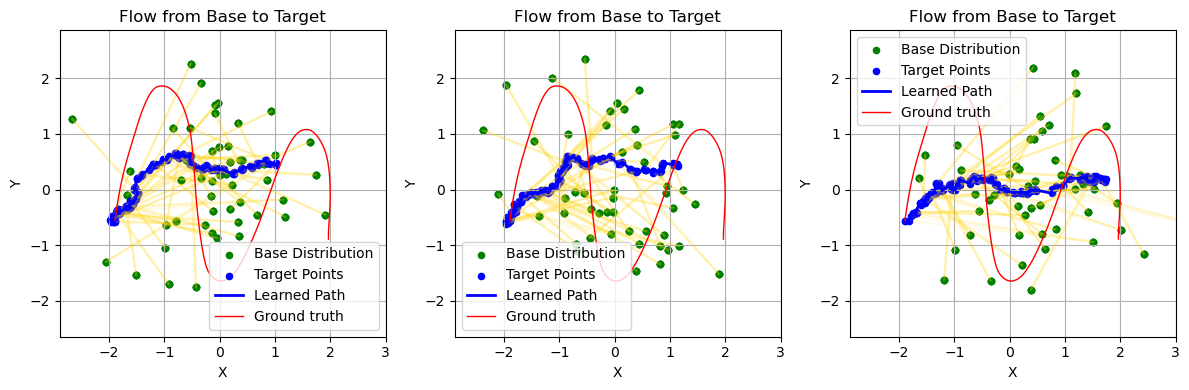

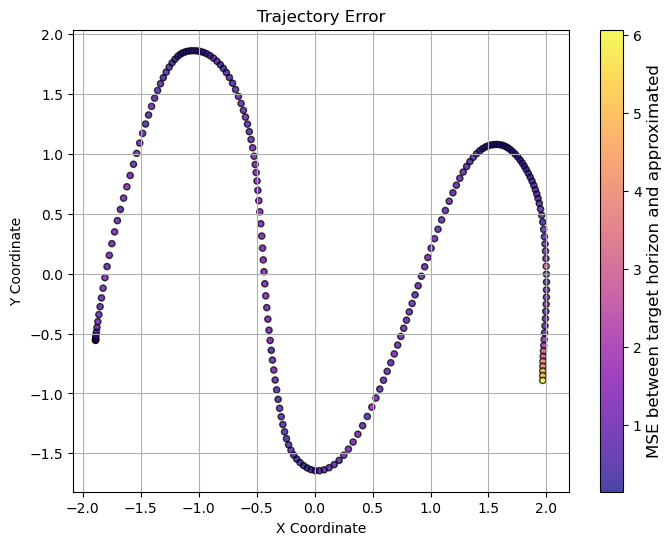

| iter   4500 | 41.71 ms/step | loss    0.109 
| iter   4500 | validation loss:    0.092 
| iter   5000 | 18.70 ms/step | loss    0.101 
| iter   5000 | validation loss:    0.128 


100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


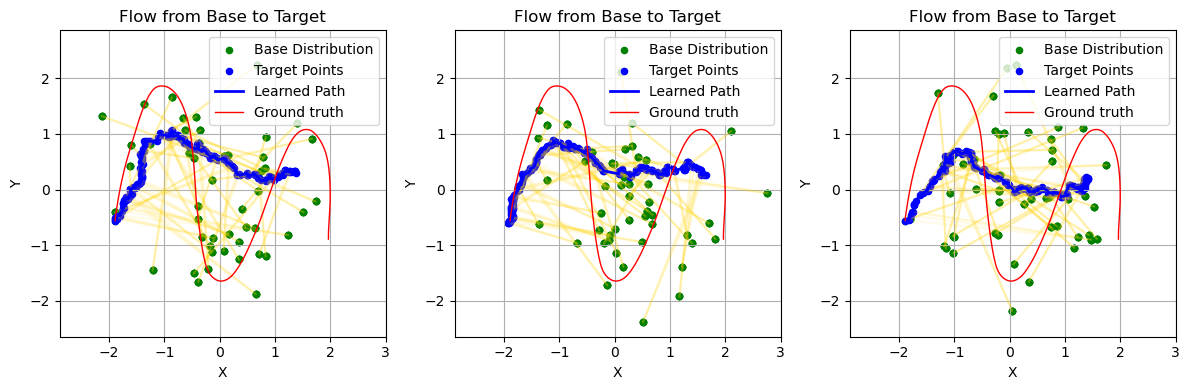

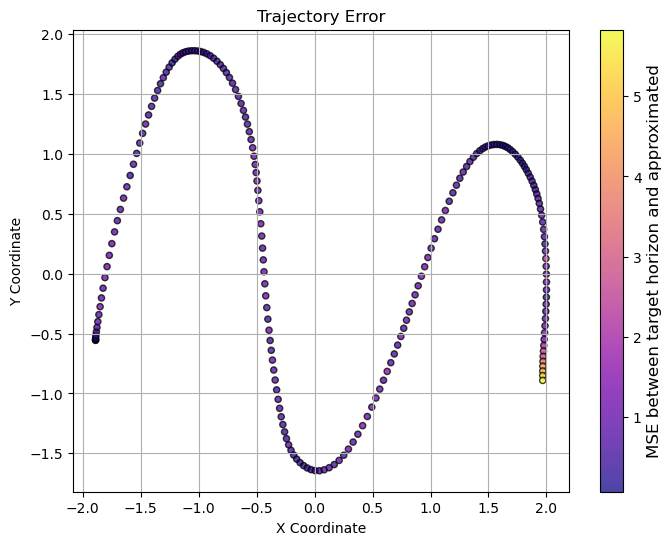

| iter   5500 | 41.45 ms/step | loss    0.119 
| iter   5500 | validation loss:    0.118 
| iter   6000 | 18.66 ms/step | loss    0.101 
| iter   6000 | validation loss:    0.089 
Saving checkpoint for 6000th epoch


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


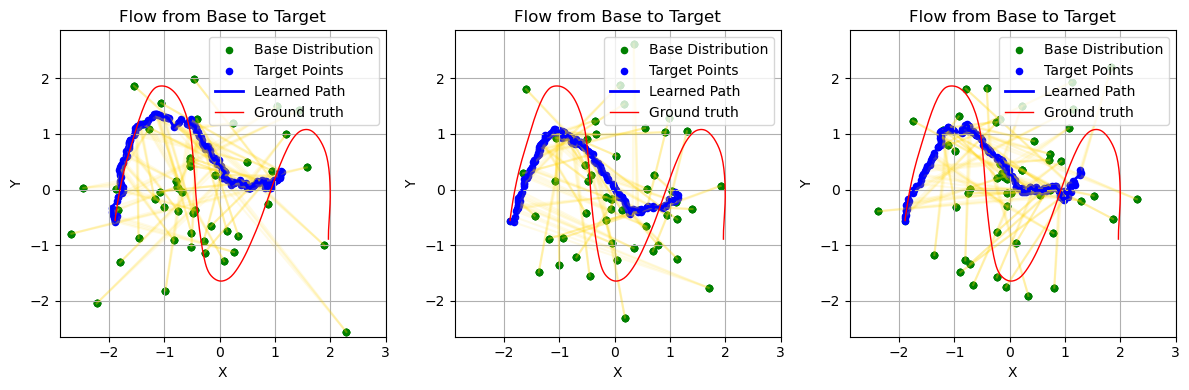

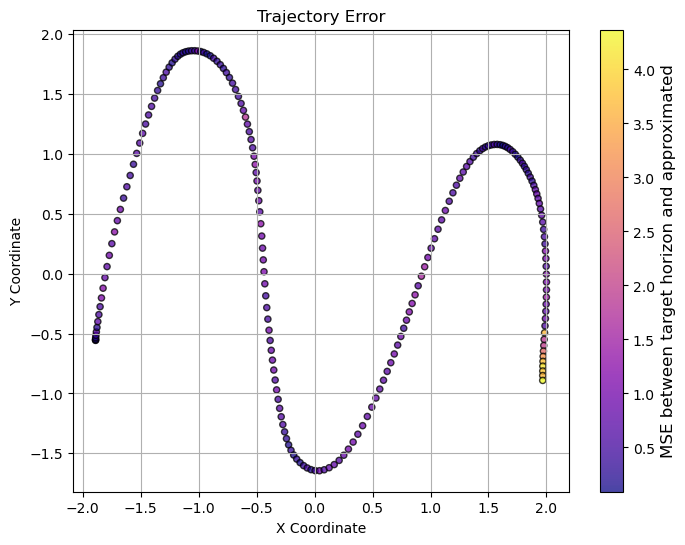

| iter   6500 | 41.88 ms/step | loss    0.094 
| iter   6500 | validation loss:    0.077 
| iter   7000 | 19.48 ms/step | loss    0.095 
| iter   7000 | validation loss:    0.101 


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


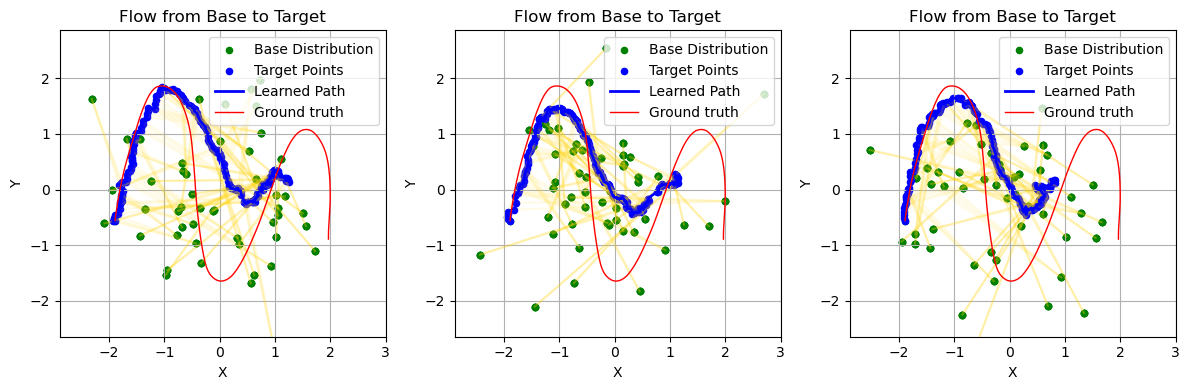

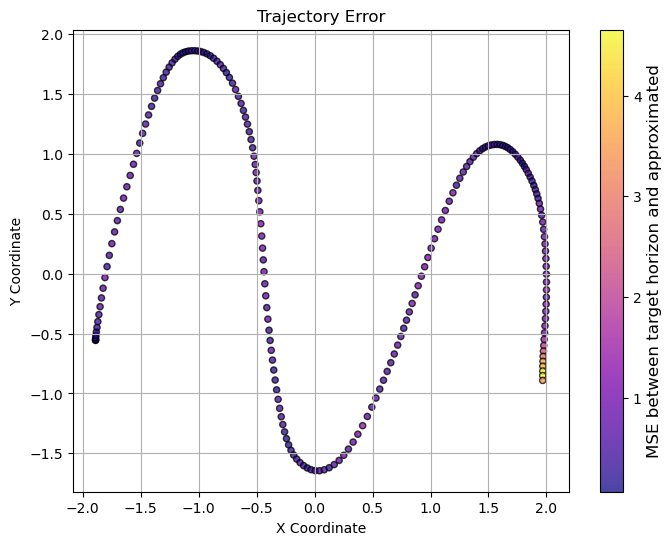

| iter   7500 | 41.85 ms/step | loss    0.082 
| iter   7500 | validation loss:    0.084 
| iter   8000 | 18.96 ms/step | loss    0.068 
| iter   8000 | validation loss:    0.082 


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


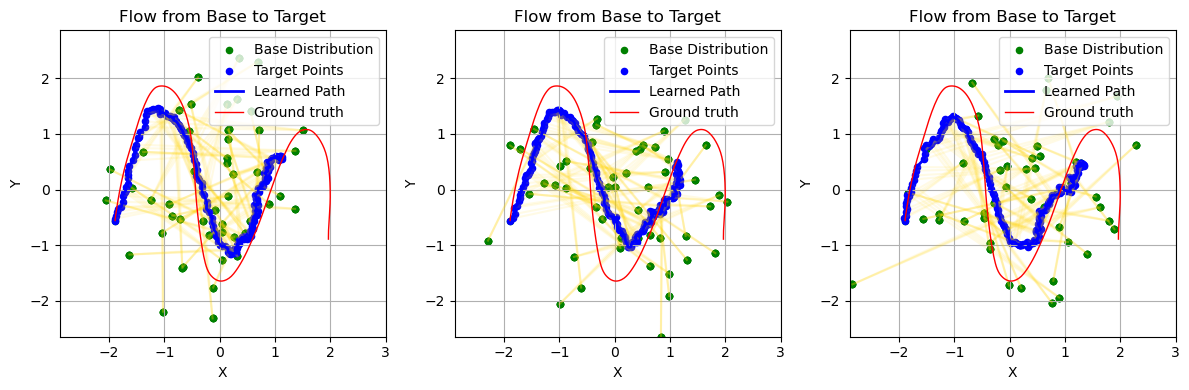

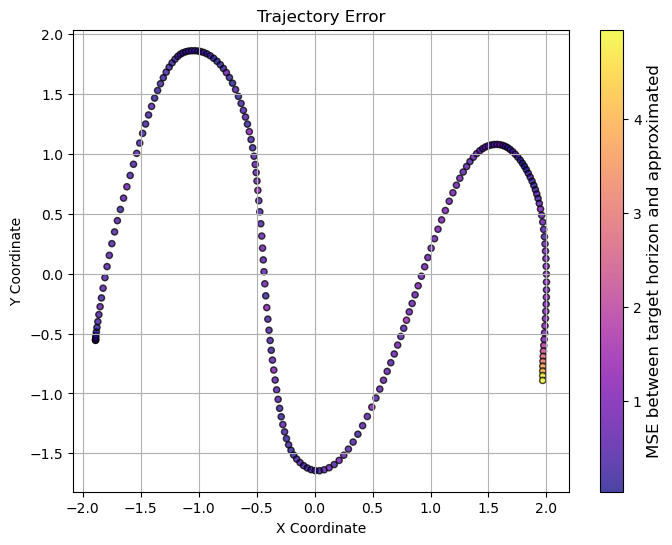

| iter   8500 | 42.04 ms/step | loss    0.070 
| iter   8500 | validation loss:    0.069 
| iter   9000 | 18.97 ms/step | loss    0.065 
| iter   9000 | validation loss:    0.057 


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


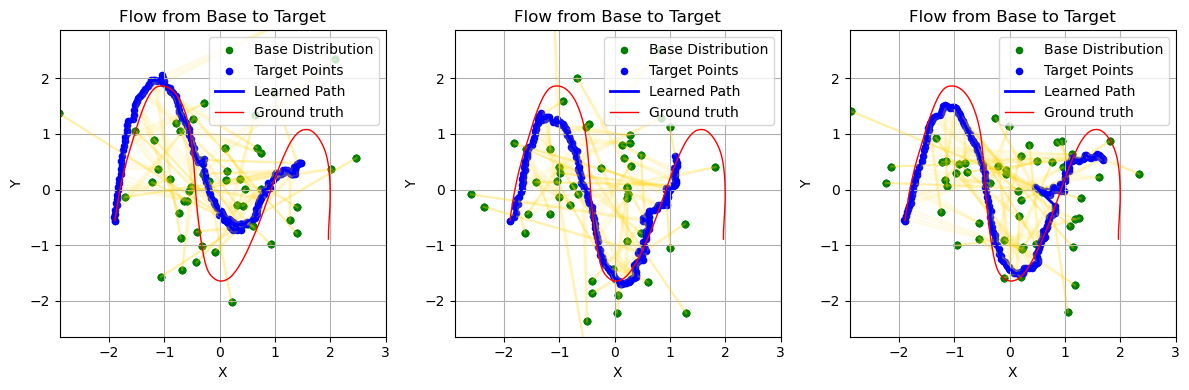

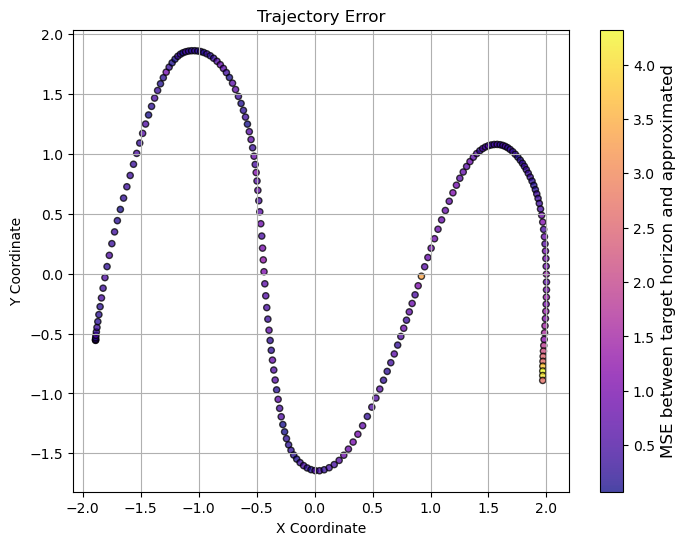

| iter   9500 | 41.23 ms/step | loss    0.057 
| iter   9500 | validation loss:    0.062 
| iter  10000 | 18.52 ms/step | loss    0.059 
| iter  10000 | validation loss:    0.048 


100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


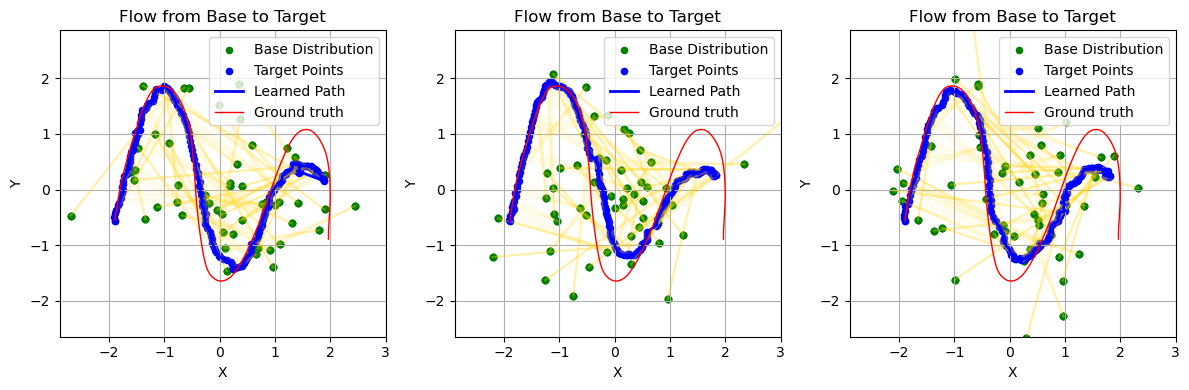

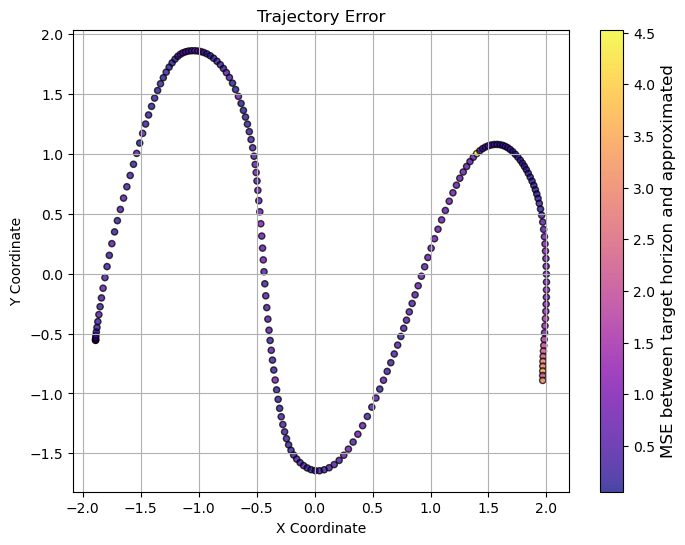

In [5]:
device = run_parameters['device']
vf.to(device)

optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['lr'])

start_time = time.time()
for i in range(run_parameters['epochs']):
  for batch in train_sin:
    optim.zero_grad()

    obs, a1 = batch
    obs, a1 = obs.to(device), a1.to(device)

    a0 = torch.randn(a1.shape[0], 1, a1.shape[2])
    a0 = a0.repeat(1, a1.shape[1], 1).to(device)

    #a0 = torch.randn_like(a1)
    t = torch.rand(a1.shape[0]).to(device)

    a_t = CondOT_flow(a0, a1, t)
    da_t = CondOT_ut(a0, a1, t)

    loss = torch.pow(vf(obs=obs, a=a_t, t=t) - da_t, 2).mean()

    loss.backward()
    optim.step()
    if i > run_parameters['ema_warmup'] and i % run_parameters['ema_update'] == 0: 
      ema_vf.update()

  if i % run_parameters['print_every'] == 0:
      elapsed = time.time() - start_time
      print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
            .format(i, elapsed*1000/run_parameters['print_every'], loss.item()))
      start_time = time.time()
      with torch.no_grad():
        ema_vf.store()
        ema_vf.copy_to()
        loss_val = validate(vf, val_sin)
        ema_vf.restore()  # Restore original weights
        print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val))
  if i > 0 and i % run_parameters['save_epoch'] == 0:
    print("Saving checkpoint for " + str(i) + "th epoch")
    torch.save(vf.state_dict(), "./vf_lipman" + str(run_parameters['scale_factor']) + "_" + str(i) + ".pth")

  if i % run_parameters['inf_every'] == 0:
    with torch.no_grad():
      ema_vf.store()
      ema_vf.copy_to()
      results = []
      samples = []
      for _ in range(run_parameters['inf_runs_num']):
        res, samp = infer_model(model=vf,
                                start=inf_obs,
                                scheme=RK4,
                                inference_horizon=run_parameters['inference_horizon'],
                                sample_points=1000//run_parameters['downsample'])
        results.append(res)
        samples.append(samp)
      error = evaluate_model(model=vf, 
                             gt_obs=gt_obs,
                             horizon_obs=gt_horizon,
                             scheme=RK4, 
                             num_steps=100)
      plot_flow(results, samples, gt_obs)
      plot_error_for_each_point(gt_obs, error)
      ema_vf.restore()
